In [1]:
%run data_acquisition.ipynb

Traemos los datos

Vamos a hacer algunas transformaciones en los datos para probar un modelo de regresion logistica con y sin ellas.

In [2]:
cat_columns = bank_df.drop('Attrition_Flag',axis=1).select_dtypes(include='object').columns
numeric_columns = bank_df.select_dtypes(include=np.number).columns

In [3]:
cat_columns

Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

In [4]:
numeric_columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

Vemos cuantas categorias diferentes tenemos para cada variable

In [5]:
lista = []
for col in cat_columns:
  info = (col, bank_df[col].nunique(), bank_df[col].unique() )
  lista.append(info)
pd.DataFrame(lista, columns=['feature', 'cantidad', 'valores'])

,feature,cantidad,valores
0,Gender,2,"[M, F]"
1,Education_Level,7,"[High School, Graduate, Uneducated, Unknown, C..."
2,Marital_Status,4,"[Married, Single, Unknown, Divorced]"
3,Income_Category,6,"[$60K - $80K, Less than $40K, $80K - $120K, $4..."
4,Card_Category,4,"[Blue, Gold, Silver, Platinum]"


En funcion de esto y de la naturaleza de las mismas, decidimos codificarlas de la siguiente forma. El nivel de educacion, nivel de ingresos y categoria de tarjeta de credito, lo codificamos con un label encoder ya que pueden ordenarse. Y las otras dos variables, que son genero y estado civil los clasificamos con un OHE ya que no tiene un ordenamiento. 

In [6]:
bank_df.Attrition_Flag.value_counts(normalize=True)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64

In [7]:
X = bank_df.drop('Attrition_Flag',axis=1)
y = bank_df['Attrition_Flag']

In [8]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2 , random_state =7 ,stratify = y)

In [9]:
X_train['Education_Level'].unique()

array(['College', 'Graduate', 'Unknown', 'High School', 'Post-Graduate',
       'Doctorate', 'Uneducated'], dtype=object)

In [10]:
X_train['Income_Category'].unique()

array(['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K',
       '$120K +', 'Unknown'], dtype=object)

In [11]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

Este sera el ordenamiento que le vamos a dar a las variables cateogricas en el OrdinalEncoder

In [12]:
orden_educacion = ['Unknown','Uneducated','Graduate','Post-Graduate','High School','College','Doctorate']
orden_income_cat = ['Unknown','Less than $40K','$40K - $60K','$60K - $80K','$80K - $120K','$120K +']
orden_card_cat = ['Blue','Silver','Gold','Platinum']

In [13]:
enc_ordenado = OrdinalEncoder(categories=[orden_educacion,orden_income_cat,orden_card_cat])

In [14]:
enc_ordenado.fit(X_train[['Education_Level','Income_Category','Card_Category']])

OrdinalEncoder(categories=[['Unknown', 'Uneducated', 'Graduate',
                            'Post-Graduate', 'High School', 'College',
                            'Doctorate'],
                           ['Unknown', 'Less than $40K', '$40K - $60K',
                            '$60K - $80K', '$80K - $120K', '$120K +'],
                           ['Blue', 'Silver', 'Gold', 'Platinum']])

In [15]:
X_train_t1 = X_train.copy()

In [16]:
X_train_t1[['Education_Level','Income_Category','Card_Category']] = enc_ordenado.transform(X_train[['Education_Level','Income_Category','Card_Category']])

Y estas seran las variables que quedan que no son numericas. Las mismas seran codificadas mediante un OHE

In [17]:
X_train_t1.select_dtypes(include='object').columns

Index(['Gender', 'Marital_Status'], dtype='object')

In [18]:
ohe = OneHotEncoder(drop='first')

In [19]:
ohe.fit(X_train_t1[['Gender','Marital_Status']])

OneHotEncoder(drop='first')

Estas que vemos a continuacion son las columnas de salida

In [20]:
ohe.get_feature_names_out(['Gender','Marital_Status'])

array(['Gender_M', 'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown'], dtype=object)

Creamos un DataFrame con las nuevas columnas codificadas

In [21]:
enc_data = pd.DataFrame(ohe.fit_transform(X_train_t1[['Gender','Marital_Status']]).toarray(),
                        columns=ohe.get_feature_names_out(['Gender','Marital_Status']),
                        index=X_train.index)

Luego creamos un nuevo DataFrame de training, uniendo el DataFrame anterior, con el generado por el OHE. Junto con esto, dropeamos las columas que ahora se encuentran codificadas ('Gender','Marital_Status')

In [22]:
X_train_t2 = X_train_t1.join(enc_data).drop(columns=['Gender','Marital_Status'])

Hacemos lo mismo con los datos de test

In [23]:
X_test_t1 = X_test.copy()
X_test_t1[['Education_Level','Income_Category','Card_Category']] = enc_ordenado.transform(X_test[['Education_Level','Income_Category','Card_Category']])

In [24]:
enc_data_2 = pd.DataFrame(ohe.fit_transform(X_test_t1[['Gender','Marital_Status']]).toarray(),
                          columns=ohe.get_feature_names_out(['Gender','Marital_Status'])
                          ,index=X_test.index)
X_test_t2 = X_test_t1.join(enc_data_2).drop(columns=['Gender','Marital_Status'])

Hacemos lo mismos con los Y

In [25]:
y_train = y_train.replace({'Attrited Customer':1,'Existing Customer':0})

In [26]:
y_test = y_test.replace({'Attrited Customer':1,'Existing Customer':0})

In [27]:
log_reg = LogisticRegression(max_iter=800,n_jobs=-1)
log_reg.fit(X_train_t2,y_train)
pred_log_reg = log_reg.predict(X_test_t2)

## Resultados LogisticRegression

In [28]:
print(classification_report(y_test, pred_log_reg))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1701
           1       0.74      0.45      0.56       325

    accuracy                           0.89      2026
   macro avg       0.82      0.71      0.75      2026
weighted avg       0.88      0.89      0.88      2026



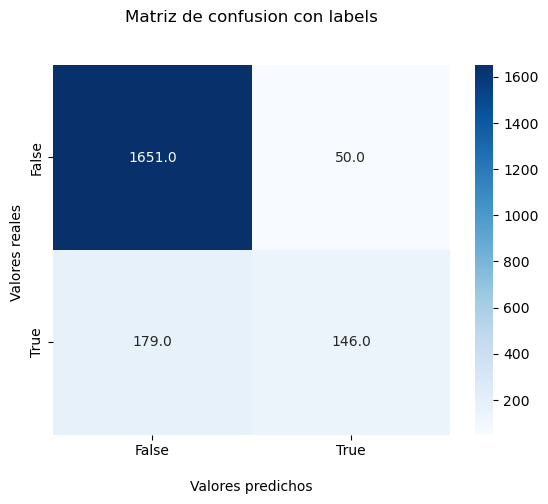

In [29]:
#Matriz de confusion
cf_matrix = confusion_matrix(y_test, pred_log_reg)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.1f')
ax.set_title('Matriz de confusion con labels\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

## Resultados KNeighborsClassifier

In [30]:
knn = KNeighborsClassifier(n_neighbors=9) # Instanciamos el clasificador k veces es decir k vecinos cercanos
knn.fit(X_train_t2, y_train)
predicciones_knn = knn.predict(X_test_t2)
print(classification_report(y_test, predicciones_knn))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1701
           1       0.74      0.55      0.63       325

    accuracy                           0.90      2026
   macro avg       0.83      0.76      0.78      2026
weighted avg       0.89      0.90      0.89      2026



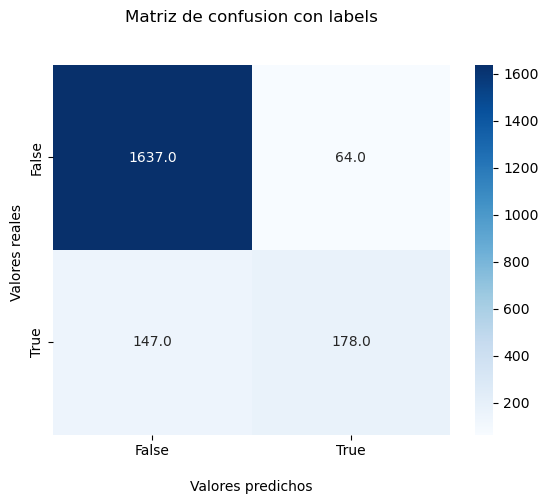

In [31]:
#Matriz de confusion
cf_matrix = confusion_matrix(y_test, predicciones_knn)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.1f')
ax.set_title('Matriz de confusion con labels\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

## Resultados RandomForestClassifier

In [32]:
clf = RandomForestClassifier(n_estimators = 100,
                             max_depth=5, 
                             random_state=0,
                             criterion = 'gini')
clf.fit(X_train_t2, y_train)
y_pred_RFC = clf.predict(X_test_t2)

In [33]:
print(classification_report(y_test, y_pred_RFC))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1701
           1       0.91      0.54      0.68       325

    accuracy                           0.92      2026
   macro avg       0.91      0.76      0.81      2026
weighted avg       0.92      0.92      0.91      2026



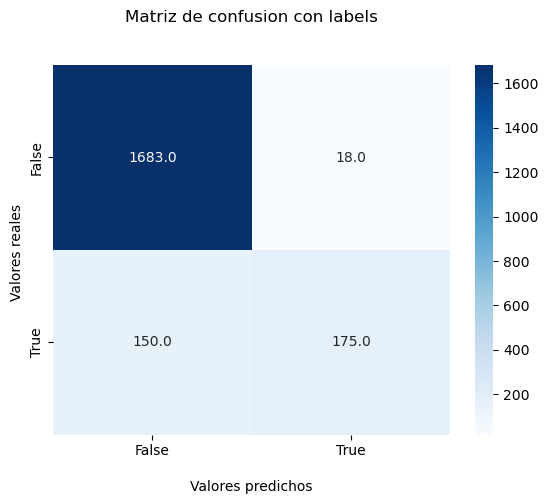

In [34]:
#Matriz de confusion
cf_matrix = confusion_matrix(y_test, y_pred_RFC)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.1f')
ax.set_title('Matriz de confusion con labels\n\n');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()